## Random Forest Regession Implementation step by step

Most of the code is copied and modifed from the different implementations in Notes.ipynb, take aways from the previous version that needs chaning implementation to t+24h forcast instead of t+6h. This along with energy data is seen as "true" meaning it cannot be used for training and testing straight away. Instead you would need to have it as a seperate target which sounds like a headace because boa is affected by the market and I'm not even going to attempt. Regardless something simple coud be tested to be implemented but only if time is avalible.

In [1]:
# Import Libraries and preprocces data
import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

model_table = pd.read_csv("data/forecast_data_merged_3.csv")
# convert to datetime
model_table["ref_datetime"] = pd.to_datetime(model_table["ref_datetime"])
model_table["valid_datetime"] = pd.to_datetime(model_table["valid_datetime"])

In [2]:
# Drop the True values
columns_to_remove = ["dtm", "Solar_MW", "Wind_MW", 
                    "wind_curtailment_MW", "wind_potential_MW", 
                    "Solar_MWh_credit", "Wind_MWh_credit",
                    "total_generation_MWh"]

model_table = model_table.drop(columns_to_remove, axis=1)
display(model_table)

,ref_datetime,valid_datetime,dwd_RelativeHumidity,dwd_WindDirection_100,dwd_WindSpeed_100,dwd_CloudCover,dwd_SolarDownwardRadiation,dwd_Temperature,ncep_RelativeHumidity,ncep_WindDirection_100,ncep_WindSpeed_100,ncep_CloudCover,ncep_SolarDownwardRadiation,ncep_Temperature
0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,85.213750,62.085170,11.802604,0.450405,0.000000,13.646173,84.066666,58.721077,11.338991,0.026000,0.0,13.940016
1,2020-09-20 00:00:00+00:00,2020-09-20 00:30:00+00:00,85.012270,61.726974,11.648818,0.472211,0.000000,13.658508,84.433334,58.494644,11.516161,0.039000,0.0,13.896579
2,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,84.810780,61.368782,11.495032,0.494018,0.000000,13.670843,84.800000,58.268215,11.693331,0.052000,0.0,13.853142
3,2020-09-20 00:00:00+00:00,2020-09-20 01:30:00+00:00,84.357895,61.111046,11.354128,0.520214,0.000000,13.732101,84.933334,59.550636,11.716686,0.038500,0.0,13.847113
4,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,83.905000,60.853313,11.213223,0.546410,0.000000,13.793360,85.066666,60.833060,11.740043,0.025000,0.0,13.841084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3459719,2023-10-27 00:00:00+00:00,2023-10-27 21:30:00+00:00,80.259060,177.495090,2.620757,0.549926,-0.003020,8.741467,81.200000,203.196010,5.695431,0.144725,0.0,8.939343
3459720,2023-10-27 00:00:00+00:00,2023-10-27 22:00:00+00:00,79.186960,172.861190,2.756149,0.585028,-0.011098,8.610748,80.122220,209.989490,5.170937,0.215100,0.0,8.804339
3459721,2023-10-27 00:00:00+00:00,2023-10-27 22:30:00+00:00,79.410890,173.374680,3.079223,0.676564,-0.004312,8.533447,79.872220,208.122830,5.281261,0.369525,0.0,8.769360
3459722,2023-10-27 00:00:00+00:00,2023-10-27 23:00:00+00:00,79.634820,173.888170,3.402297,0.768100,0.002474,8.456146,79.622220,206.256160,5.391584,0.523950,0.0,8.734381


Now the fun begins, so the thing is with these forcasts is that every 6 hours we get a 50h forcast (technically more but it's not included, feel free to do so if you want). This means that the forcasts actually overlapp eachother. We need to process this before creating traning and testing splits. Unfortunetly there are a plethera of methods that can be used to handle this simplest being just cutting of the overlapping time spand to the most resent forcast, other ways consist of weight the most resent forcast being heavier, other method could be taking means of overlapping time. One could also do seperate forcasts for each of the overlaps and take the best result. But instead of writing funny words, let's do 2 different types of additional preprocessing:

1. numero uno taking the most resent forcast 
2. numero dos taking the mean over overlapping forcasts.

## Additional Preprocessing of data generally

välkommen till mitt personliga helvete

In [3]:
# Som man kan säga första lösningen är sällan den bästa, detta är en förnyad version av mitt tiddiagre prepross scritps 

## le dernier est le meilleur; den senaste är den bästa 
# Assuming the lastest forcast is the best forcast
X_latest_forcast = pd.DataFrame() 
num_day = model_table["ref_datetime"].dt.date.nunique()
# print(num_day)
# 1133 good value 

first_day = pd.Timestamp("2020-09-20 00:00:00+00:00")

# Now we mask for all day, bit slow but it works
for d in range(num_day):
       start = (first_day + timedelta(hours=18)) + timedelta(days=d)
       end = start + timedelta(hours=24)
       mask = (model_table["ref_datetime"] == start) &\
              (model_table["valid_datetime"] >= start + timedelta(hours=6)) &\
              (model_table["valid_datetime"] < end + + timedelta(hours=6))
       X_latest_forcast = pd.concat([X_latest_forcast, model_table.loc[mask]])


## Mean of several overlapping forcasts 
X_raw = model_table.copy()

# filter for D-1
X_raw["target_day"] = X_raw["valid_datetime"].dt.date
X_raw["reference_day"] = X_raw["ref_datetime"].dt.date
X_raw_filtered = X_raw[X_raw["reference_day"] == (X_raw["target_day"] - pd.Timedelta(days=1))]

# aggregate mean, very fast very nice yes yes 
X_overlapp_mean = X_raw_filtered.groupby("valid_datetime", as_index=False).agg({
    "dwd_RelativeHumidity": "mean",
    "dwd_WindDirection_100": "mean",
    "dwd_WindSpeed_100": "mean",	
    "dwd_CloudCover": "mean",
    "dwd_SolarDownwardRadiation": "mean",	
    "dwd_Temperature": "mean",
    "ncep_RelativeHumidity": "mean",
    "ncep_WindDirection_100": "mean",
    "ncep_WindSpeed_100": "mean",
    "ncep_CloudCover": "mean",	
    "ncep_SolarDownwardRadiation": "mean",	
    "ncep_Temperature": "mean",
    "ref_datetime": ["first", "count"]  # Keep one value + count
})

# flatten the multiIndex columns
X_overlapp_mean.columns = [
    "_".join(col) if isinstance(col, tuple) else col 
    for col in X_overlapp_mean.columns
]

# rename 
X_overlapp_mean = X_overlapp_mean.rename(columns={
    "ref_datetime_first": "ref_datetime",
    "ref_datetime_count": "n_forecasts",
    "dwd_RelativeHumidity_mean": "dwd_RelativeHumidity",
    "dwd_WindDirection_100_mean": "dwd_WindDirection_100",
    "dwd_WindSpeed_100_mean": "dwd_WindSpeed_100",
    "dwd_CloudCover_mean": "dwd_CloudCover",
    "dwd_SolarDownwardRadiation_mean": "dwd_SolarDownwardRadiation",	
    "dwd_Temperature_mean": "dwd_Temperature",
    "ncep_RelativeHumidity_mean": "ncep_RelativeHumidity",
    "ncep_WindDirection_100_mean": "ncep_WindDirection_100",
    "ncep_WindSpeed_100_mean": "ncep_WindSpeed_100",
    "ncep_CloudCover_mean": "ncep_CloudCover",
    "ncep_SolarDownwardRadiation_mean": "ncep_SolarDownwardRadiation",
    "ncep_Temperature_mean": "ncep_Temperature",
    "valid_datetime_": "valid_datetime"
})


Let check so see that I didn't goof 

In [5]:
#display(X_latest_forcast) # 54336 rows × 14 columns, dates look good lets move on 
#display(X_overlapp_mean) # 54336 rows × 14 columns, 4 overlapps as it should be for 50 hours, not this is for the second version

# Gifts
#X_overlapp_mean.to_csv("data/forecast_data_om.csv", index=False)
#X_latest_forcast.to_csv("data/forecast_data_lf.csv", index=False)

Summan av kardemumman, ovandligen av datan har blandat om ordningen på målen så man måste ladda om,
notera också att från modeling_table att CVS förkastas i början av filen nu

In [4]:
# REDO WHAT WAS DONE IN prepross.py 
energy_data = pd.read_csv("data/Energy_Data_20200920_20231027.csv")

energy_data["dtm"] = pd.to_datetime(energy_data["dtm"])

energy_data_dtm = energy_data["dtm"]
energy_data_Solar = energy_data["Solar_MW"]
energy_data_Wind = energy_data["Wind_MW"]
energy_data_wind_curtailment = energy_data["boa_MWh"]

energy_data_Solar = energy_data_Solar.sort_index()
energy_data_Solar.interpolate(method='linear', inplace=True)
energy_data["Solar_MW"] = energy_data_Solar

energy_data_Wind = energy_data_Wind.sort_index()
energy_data_Wind.interpolate(method='linear', inplace=True)
energy_data["Wind_MW"] = energy_data_Wind

energy_data_wind_curtailment = energy_data_wind_curtailment.sort_index()
energy_data_wind_curtailment.interpolate(method='linear', inplace=True)
energy_data["boa_MWh"] = energy_data_wind_curtailment

energy_data["Wind_MWh_credit"] = 0.5*energy_data["Wind_MW"] - energy_data["boa_MWh"]
energy_data["Solar_MWh_credit"] = 0.5*energy_data["Solar_MW"]
energy_data["total_generation_MWh"] = energy_data["Wind_MWh_credit"] + energy_data["Solar_MWh_credit"]

# Now we have y, note that first day has been removed as we don't have X for the first day
y_all = energy_data[["dtm", "Wind_MWh_credit", "Solar_MWh_credit", "total_generation_MWh", "boa_MWh"]][48:]

# y_all.to_csv("data/target_train.csv", index=False)
# display(y_all) # 54336 rows × 5 columns, good good same num of rows,as X, dates look good, we gucci 

okei, hyvä jotto

Currently we've got X and y but they're pretty raw, lets start cooking. These are the steps before we're done. Some of these steps will use a pipeline.

1. Verify inputs, might be redundant but in the case that X and y changes in future it can be fallaged for
2. Split X and y into solar wind and train and test
3. (pipe) Feauture engineering, this will have several internal steps


In [5]:
# Split intor trainin and testing
# 65% and 35 % split
#split_date = pd.Timestamp("2022-10-01 00:00:00+00:00")

# 80 %  and 20 % split 
split_date = pd.Timestamp("2023-03-15 00:00:00+00:00")

# mo = mean overlapp
X_train_mo = X_overlapp_mean[X_overlapp_mean["valid_datetime"] < split_date].copy()
X_test_mo = X_overlapp_mean[X_overlapp_mean["valid_datetime"] >= split_date].copy()

# lf = latest forcast
X_train_lf = X_latest_forcast[X_latest_forcast["valid_datetime"] < split_date].copy()
X_test_lf = X_latest_forcast[X_latest_forcast["valid_datetime"] >= split_date].copy()

wind_features = ["valid_datetime","dwd_RelativeHumidity", "dwd_WindDirection_100", "dwd_WindSpeed_100",
                "ncep_RelativeHumidity", "ncep_WindDirection_100", "ncep_WindSpeed_100"]

solar_features = ["valid_datetime","dwd_CloudCover", "dwd_SolarDownwardRadiation", "dwd_Temperature",
                "ncep_CloudCover", "ncep_SolarDownwardRadiation", "ncep_Temperature"]

# seperate into solar and wind
X_train_solar_mo = X_train_mo[solar_features]
X_test_solar_mo = X_test_mo[solar_features]
X_train_wind_mo = X_train_mo[wind_features]
X_test_wind_mo = X_test_mo[wind_features]

X_train_solar_lf = X_train_lf[solar_features]
X_test_solar_lf = X_test_lf[solar_features]
X_train_wind_lf = X_train_lf[wind_features]
X_test_wind_lf = X_test_lf[wind_features]

# take out targets
y_all_train = y_all[y_all["dtm"] < split_date].copy()
y_all_test = y_all[y_all["dtm"] >= split_date].copy()

y_train_solar = y_all_train["Solar_MWh_credit"]
y_test_solar = y_all_test["Solar_MWh_credit"]

y_train_wind = y_all_train["Wind_MWh_credit"]
y_test_wind = y_all_test["Wind_MWh_credit"]

# wps = wind plus solar 
y_train_wps = y_all_train["total_generation_MWh"]
y_test_wps = y_all_test["total_generation_MWh"]

# time vectors used for verification of dates
t_train = y_all_train["dtm"]
t_test = y_all_test["dtm"]

# Check for goofy 
#display(t_train)
#display(X_train_solar_lf)
#print(len(t_train))
#print(len(X_train_solar_lf))
# Same lenght and valid datetime lines up with dtm

#display(t_test)
#display(X_test_solar_lf)
#print(len(t_test))
#print(len(X_test_solar_lf))
# Same lenght and valid datetime lines up with dtm

#print(X_test_solar_mo.head())
#print("-"*50)
#print(X_train_solar_mo.head())

In [6]:
# Custom classes

# 3. Feauter Engineering
from sklearn.base import BaseEstimator, TransformerMixin

# 3.1 Costum cyclic transformer, transforms wind if necessary
class CyclicFeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self, datetime_col = "valid_datetime", wind_dir_cols=None, drop_original=True):
        self.datetime_col = datetime_col
        self.wind_dir_cols = wind_dir_cols or []
        self.drop_original = drop_original
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_ = X.copy()
        dt_col = pd.to_datetime(X_[self.datetime_col])
        X_["hour_sin"] = np.sin(2*np.pi*(dt_col.dt.hour + dt_col.dt.minute/60)/24)
        X_["hour_cos"] = np.cos(2*np.pi*(dt_col.dt.hour + dt_col.dt.minute/60)/24)
        X_["weekday_sin"] = np.sin(2*np.pi * dt_col.dt.weekday/7)
        X_["weekday_cos"] = np.cos(2*np.pi*dt_col.dt.weekday/7)
        X_["month_sin"] = np.sin(2*np.pi*dt_col.dt.month/12)
        X_["month_cos"] = np.cos(2*np.pi*dt_col.dt.month/12)
        
        # Add cyclic wind direction features (if any)
        for col in self.wind_dir_cols:
            radians = np.deg2rad(X_[col])
            X_[f"{col}_sin"] = np.sin(radians)
            X_[f"{col}_cos"] = np.cos(radians)
            dt_col = pd.to_datetime(X_[self.datetime_col])

        # Drop original datetime and wind_dir columns if specified
        if self.drop_original:
            drop_cols = [self.datetime_col] + self.wind_dir_cols
            X_ = X_.drop(columns=drop_cols)

        return X_


# 3.2 Lag desired columns
class LagFeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self, columns, lags=[-2, -1, 0, 1, 2], drop_original=True):
        self.columns = columns
        self.lags = lags
        self.drop_original = drop_original
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_ = X.copy()
        for col in self.columns:
            for lag in self.lags:
                X_[f'{col}_lag{lag}'] = X_[col].shift(lag)

        if self.drop_original:
            X_.drop(columns=self.columns, inplace=True)
        
        return X_


brrrrrrrrrrrrrr

Additional preprocessing steps:
1. Cyclic (works)
2. lag (works)
3. Imputer (works, but returns an array)
4. Scaler (works, but returns an array)

Great well I don't want arrays, so I'll create another costum function, 3 and 4 are now a class

SKRÄP, nej scalern är utanför så jag kan använda samma scaler senare utan att läcka 

Now we can start running the model


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

wind_dir_col = ["dwd_WindDirection_100", "ncep_WindDirection_100"]
wind_lag_col = ["dwd_RelativeHumidity", "dwd_WindSpeed_100",
                "ncep_RelativeHumidity", "ncep_WindSpeed_100"]
solar_lag_col = ["dwd_CloudCover", "dwd_SolarDownwardRadiation", "dwd_Temperature",
                 "ncep_CloudCover", "ncep_SolarDownwardRadiation", "ncep_Temperature"]

# Pipeline for wind data
feature_engineering_wind = Pipeline([
    ("cyclic", CyclicFeatureAdder(datetime_col="valid_datetime", wind_dir_cols=wind_dir_col, drop_original=True)),
    ("lag", LagFeatureAdder(columns=wind_lag_col, drop_original=True)),
    ("imputer", SimpleImputer())
    ], verbose=True)

# Pipeline for solar data
feature_engineering_solar = Pipeline([
    ("cyclic", CyclicFeatureAdder(datetime_col="valid_datetime", wind_dir_cols=None, drop_original=True)),
    ("lag", LagFeatureAdder(columns=solar_lag_col, drop_original=True)),
    ("imputer", SimpleImputer())
    ], verbose=True)

# Look at transformed sets they,
#X_train_transformed = feature_engineering_solar.fit_transform(X_test_solar_lf)
#print(X_train_transformed)
#print(type(X_train_transformed))
#X_train_transformed = feature_engineering_wind.fit_transform(X_train_wind_mo)
#print(X_train_transformed.head(0))



 SOLAR
[Pipeline] ............ (step 1 of 3) Processing cyclic, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing lag, total=   0.0s
[Pipeline] ........... (step 3 of 3) Processing imputer, total=   0.0s
[Pipeline] ............ (step 1 of 3) Processing cyclic, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing lag, total=   0.0s
[Pipeline] ........... (step 3 of 3) Processing imputer, total=   0.0s
Solar MAPE: 29.11839612030564


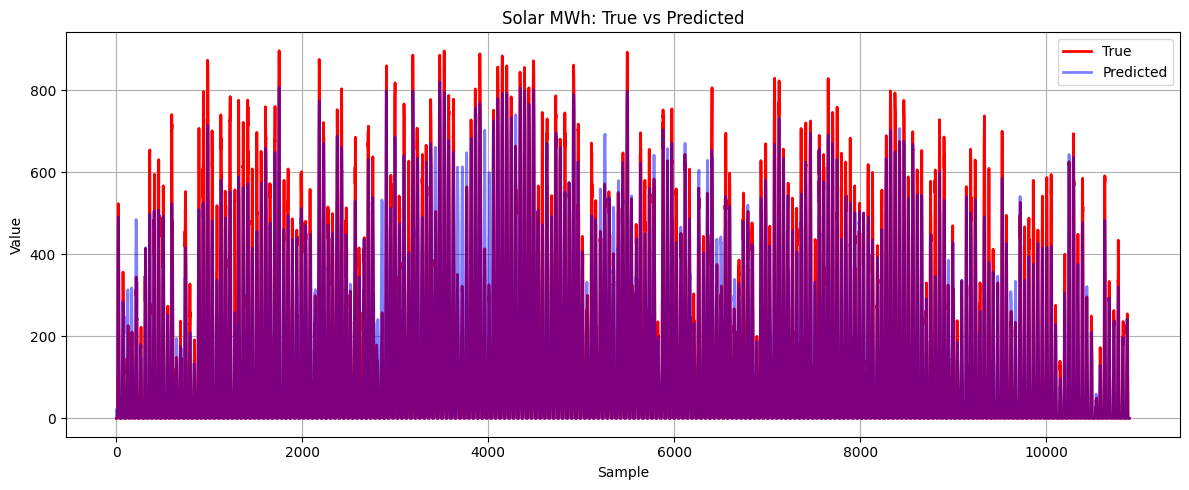


 WIND
[Pipeline] ............ (step 1 of 3) Processing cyclic, total=   0.1s
[Pipeline] ............... (step 2 of 3) Processing lag, total=   0.0s
[Pipeline] ........... (step 3 of 3) Processing imputer, total=   0.0s
[Pipeline] ............ (step 1 of 3) Processing cyclic, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing lag, total=   0.0s
[Pipeline] ........... (step 3 of 3) Processing imputer, total=   0.0s
Wind MAPE: 113.1268204820064


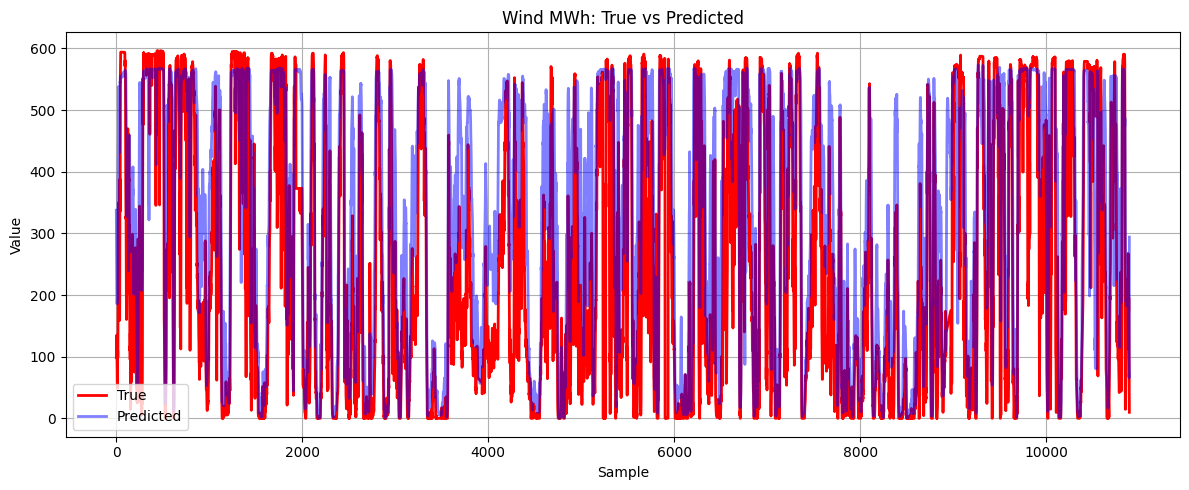

WPS MAPE: 117.43123052427428


In [8]:
# No quantile random forest

# scaler functions
def scale_features(arr, scaler=None):
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_arr = scaler.fit_transform(arr)
    else:
        scaled_arr = scaler.transform(arr)
    
    return scaled_arr, scaler

def scale_target(series, scaler=None):
    values = series.values.reshape(-1,1)
    
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(values)
    else:
        scaled_values = scaler.transform(values)
    
    scaled_series = pd.Series(scaled_values.flatten(), 
                            index=series.index, 
                            name=series.name)
    
    return scaled_series, scaler

rf_solar = RandomForestRegressor(
    n_estimators=500,
    max_depth=14,
    min_samples_split=10,    
    random_state=42,
    criterion='squared_error',
    n_jobs=-1
)

print("\n SOLAR")

X_train_solar = feature_engineering_solar.fit_transform(X_train_solar_lf)
X_train_solar, solar_scale = scale_features(arr=X_train_solar, scaler=None)
X_test_solar = feature_engineering_solar.fit_transform(X_test_solar_lf)
X_test_solar, _ = scale_features(arr=X_test_solar, scaler=solar_scale)

y_trains_solar_scaled, solar_scale_y = scale_target(series=y_train_solar, scaler=None)

rf_solar.fit(X_train_solar, y_trains_solar_scaled)

y_pred_solar = rf_solar.predict(X_test_solar)

y_pred_solar = solar_scale_y.inverse_transform(y_pred_solar.reshape(-1, 1))

print("Solar MAPE:", mean_absolute_error(y_test_solar, y_pred_solar))

plt.figure(figsize=(12, 5))
plt.plot(y_test_solar.values, label='True', linewidth=2, color="red")
plt.plot(y_pred_solar, label='Predicted', linewidth=2, color="blue", alpha=0.5)

plt.title("Solar MWh: True vs Predicted")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Wind model
rf_wind = RandomForestRegressor(
    n_estimators=500,
    max_depth=14,
    min_samples_split=10,    
    random_state=42,
    criterion='squared_error',
    n_jobs=-1
)

print("\n WIND")

wind_pipeline = Pipeline([
    ("preprocessing", feature_engineering_wind)])

X_train_wind = feature_engineering_wind.fit_transform(X_train_wind_lf)
X_train_wind, wind_scale = scale_features(arr=X_train_wind, scaler=None)
X_test_wind = feature_engineering_wind.fit_transform(X_test_wind_lf)
X_test_wind, _ = scale_features(arr=X_test_wind, scaler=None)

y_trains_wind_scaled, wind_scale_y = scale_target(series=y_train_wind, scaler=None)

rf_wind.fit(X_train_wind, y_trains_wind_scaled)

y_pred_wind = rf_wind.predict(X_test_wind)

y_pred_wind = wind_scale_y.inverse_transform(y_pred_wind.reshape(-1, 1))

print("Wind MAPE:", mean_absolute_error(y_test_wind, y_pred_wind))

plt.figure(figsize=(12, 5))
plt.plot(y_test_wind.values, label='True', linewidth=2,  color="red")
plt.plot(y_pred_wind, label='Predicted', linewidth=2, color="blue", alpha=0.5)

plt.title("Wind MWh: True vs Predicted")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# combined
y_pred_wps = y_pred_wind + y_pred_solar

print("WPS MAPE:", mean_absolute_error(y_test_wps, y_pred_wps))

# 65% and 35% split 
# Solar MAE 25.15970837269746, Wind MAE 107.29377596014007, WPS MAE 112.18167085234462, took 4 min (y is scaled)

# 80% / 20% split 
# Solar MAE 29.11839612030564, Wind MAE 113.1268204820064, WPS MAE 117.43123052427428, took 5 min (y is scaled)

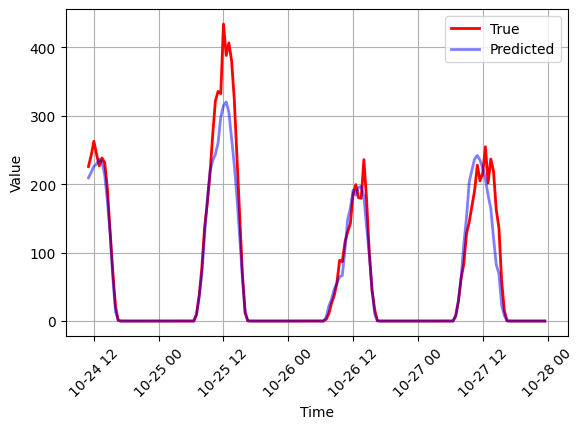

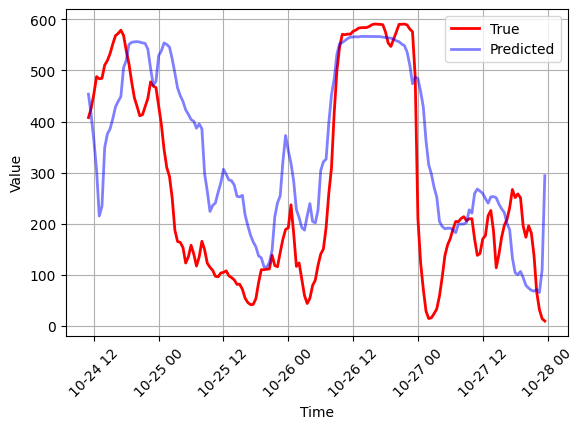

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(t_test[-170:], y_test_solar.values[-170:], label='True', linewidth=2, color="red")
plt.plot(t_test[-170:], y_pred_solar[-170:], label='Predicted', linewidth=2, color="blue", alpha=0.5)

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(t_test[-170:], y_test_wind.values[-170:], label='True', linewidth=2,  color="red")
plt.plot(t_test[-170:], y_pred_wind[-170:], label='Predicted', linewidth=2, color="blue", alpha=0.5)

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

Well that went well a MAPE of hipoputumous gasizlion, it's due to that we hadle values close to zero. Stick to MAE. Regardless lets move on to quantiles

In [8]:
# quantiles with spes lib, no search

from quantile_forest import RandomForestQuantileRegressor

# scaler functions
def scale_features(arr, scaler=None):
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_arr = scaler.fit_transform(arr)
    else:
        scaled_arr = scaler.transform(arr)
    
    return scaled_arr, scaler

def scale_target(series, scaler=None):
    values = series.values.reshape(-1,1)
    
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(values)
    else:
        scaled_values = scaler.transform(values)
    
    scaled_series = pd.Series(scaled_values.flatten(), 
                            index=series.index, 
                            name=series.name)
    return scaled_series, scaler

def pinball(y, q, alpha):
    return (y - q) * alpha * (y >= q) + (q - y) * (1 - alpha) * (y < q)

def pinball_score(df):
    scores = [
        pinball(
            y=df["total_generation_MWh"],
            q=df[f"q{qu}"],
            alpha=qu/100
        ).mean()
        for qu in range(10, 100, 10)
    ]
    return np.mean(scores)

rfq_solar = RandomForestQuantileRegressor( n_estimators=500,
                                        max_depth=14,
                                        min_samples_split=10,    
                                        random_state=42,
                                        criterion="squared_error",
                                        n_jobs = -1)

print("fitting solar")
X_train_solar = feature_engineering_solar.fit_transform(X_train_solar_lf)
X_train_solar_scaled, solar_scale = scale_features(arr=X_train_solar, scaler=None)

X_test_solar = feature_engineering_solar.fit_transform(X_test_solar_lf)
X_test_solar_scaled, _ = scale_features(arr=X_test_solar, scaler=solar_scale)

y_train_solar_scaled, y_sun_scale = scale_target(y_train_solar, scaler=None)

y_p_solar = rfq_solar.fit(X_train_solar_scaled, y_train_solar_scaled)

rfq_wind = RandomForestQuantileRegressor( n_estimators=500,
                                        max_depth=14,
                                        min_samples_split=10,    
                                        random_state=42,
                                        criterion="squared_error",
                                        n_jobs = -1)

print("fitting wind")
X_train_wind = feature_engineering_wind.fit_transform(X_train_wind_lf, y_train_wind)
X_train_wind_scaled, wind_scale = scale_features(arr=X_train_wind, scaler=None)

X_test_wind = feature_engineering_wind.fit_transform(X_test_wind_lf)
X_test_wind_scaled, _ = scale_features(arr=X_test_wind, scaler=wind_scale)

y_train_wind_scaled, y_wind_scale = scale_target(y_train_wind, scaler=None)

rfq_wind.fit(X_train_wind_scaled, y_train_wind_scaled)

quant = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

print("predicting solar")
y_p_solar = rfq_solar.predict(X_test_solar_scaled, quantiles=quant)

print("predicting wind")
y_p_wind = rfq_wind.predict(X_test_wind_scaled, quantiles=quant)

print("finalizing")
#y_p = y_p_wind + y_p_solar

y_p_wind_unscaled = y_wind_scale.inverse_transform(y_p_wind)

y_p_solar_unscaled = y_sun_scale.inverse_transform(y_p_solar)

y_p_scaled = y_p_wind_unscaled + y_p_solar_unscaled

#  solar 
df_solar = pd.DataFrame(
    y_p_solar_unscaled, 
    columns=[f"q{int(q*100)}" for q in quant]
)
df_solar["total_generation_MWh"] = y_test_solar.reset_index(drop=True)  # use true solar

# wind
df_wind = pd.DataFrame(
    y_p_wind_unscaled,
    columns=[f"q{int(q*100)}" for q in quant]
)
df_wind["total_generation_MWh"] = y_test_wind.reset_index(drop=True)  # use true wind

# combined
df_preds = pd.DataFrame(
    y_p_scaled,
    columns=[f"q{int(q*100)}" for q in quant]
)
df_preds["total_generation_MWh"] = y_test_wps.reset_index(drop=True)  # true combined

# score all three
score_total = pinball_score(df_preds)
score_solar = pinball_score(df_solar)
score_wind  = pinball_score(df_wind)

print(f"Pinball score (Total): {score_total:.4f}")
print(f"Pinball score (Solar): {score_solar:.4f}")
print(f"Pinball score (Wind):  {score_wind:.4f}")

# I've gotten the runtime from over 50 min to not even 5 min by scaleing y, and that makes me very happy
# Split 65/35
# results scaled X and y, no search
# Pinball score (Total): 27.5899
# Pinball score (Solar): 9.7413
# Pinball score (Wind):  22.4205

# Split 80/20
# results scaled X and y, no search
# Pinball score (Total): 27.5543
# Pinball score (Solar): 11.1583
# Pinball score (Wind): 21.4326


fitting solar
[Pipeline] ............ (step 1 of 3) Processing cyclic, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing lag, total=   0.0s
[Pipeline] ........... (step 3 of 3) Processing imputer, total=   0.0s
[Pipeline] ............ (step 1 of 3) Processing cyclic, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing lag, total=   0.0s
[Pipeline] ........... (step 3 of 3) Processing imputer, total=   0.0s
fitting wind
[Pipeline] ............ (step 1 of 3) Processing cyclic, total=   0.1s
[Pipeline] ............... (step 2 of 3) Processing lag, total=   0.0s
[Pipeline] ........... (step 3 of 3) Processing imputer, total=   0.0s
[Pipeline] ............ (step 1 of 3) Processing cyclic, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing lag, total=   0.0s
[Pipeline] ........... (step 3 of 3) Processing imputer, total=   0.0s
predicting solar
predicting wind
finalizing
Pinball score (Total): 27.5543
Pinball score (Solar): 11.1583
Pinball score (

In [ ]:
# METRICS copied from XGboost 
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error, mean_squared_error, r2_score

# Symetric Mean Absolute Percentage Error
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0  # avoid division by zero
    return 100 * np.mean(diff)

# Mean Absolute Percentage Error
# own function to forcefully ingore division by zero
def mape(y_true, y_pred):
    mask = y_true != 0
    return 100 * np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))

# Continuous Ranked Probability Score
def crps(y_true, quantile_preds, quantiles):
    y = y_true.reshape(-1, 1)
    q_vals = np.array(quantiles).reshape(1, -1)
    indicator = (y < quantile_preds).astype(float)
    return np.mean((indicator - q_vals) * (quantile_preds - y))

# Weighted Interval Score
def wis(y_true, quantile_preds, quantiles):
    # Assumes symmetric quantile pairs around the median
    lower_idxs = list(range(len(quantiles) // 2))
    upper_idxs = list(range(len(quantiles) - 1, len(quantiles) // 2 - 1, -1))
    
    wis_total = 0.0
    for l_idx, u_idx in zip(lower_idxs, upper_idxs):
        alpha = quantiles[u_idx] - quantiles[l_idx]
        lower = quantile_preds[:, l_idx]
        upper = quantile_preds[:, u_idx]
        range_ = upper - lower
        below = np.maximum(lower - y_true, 0)
        above = np.maximum(y_true - upper, 0)
        wis_total += range_ + 2 / alpha * below + 2 / alpha * above

    return np.mean(wis_total / len(lower_idxs))

def evaluate_forecast(df, quantiles):
    y_true = df["total_generation_MWh"].values
    y_pred = df["q50"].values
    quantile_preds = np.stack([df[f"q{int(q*100)}"].values for q in quantiles], axis=-1)
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape_ = mape(y_true, y_pred)
    smape_ = smape(y_true, y_pred)
    crps_ = crps(y_true, quantile_preds, quantiles)
    wis_ = wis(y_true, quantile_preds, quantiles)

    return {
        "MAE": mae,
        "MAPE": mape_,
        "SMAPE": smape_,
        "RMSE": rmse,
        "R2": r2,
        "CRPS": crps_,
        "WIS": wis_
    }

# No Search, training 
metrics_solar = evaluate_forecast(df_solar, quant)
metrics_wind = evaluate_forecast(df_wind, quant)
metrics_combined = evaluate_forecast(df_preds, quant)

print("Solar:", metrics_solar)
print("Wind:", metrics_wind)
print("Combined:", metrics_combined)

# Solar: {'MAE': 28.437570518522456, 'MAPE': np.float64(6133.896103839102), 'SMAPE': np.float64(18.412028972969694), 'RMSE': np.float64(55.63242890686889), 'R2': 0.9395116331258799, 'CRPS': np.float64(11.158270537151372), 'WIS': np.float64(129.84240687402146)}
# Wind: {'MAE': 54.00226812535587, 'MAPE': np.float64(1048.8768228472034), 'SMAPE': np.float64(44.929056544470605), 'RMSE': np.float64(87.61128938708318), 'R2': 0.8181972252245452, 'CRPS': np.float64(21.43259470256305), 'WIS': np.float64(247.53125877988057)}
# Combined: {'MAE': 69.12101012085888, 'MAPE': np.float64(13799.29827903796), 'SMAPE': np.float64(30.224909080876845), 'RMSE': np.float64(104.33191937780691), 'R2': 0.8714142883826324, 'CRPS': np.float64(27.554255172782216), 'WIS': np.float64(320.02603988119694)}



Solar: {'MAE': 28.437570518522456, 'MAPE': np.float64(6133.896103839102), 'SMAPE': np.float64(18.412028972969694), 'RMSE': np.float64(55.63242890686889), 'R2': 0.9395116331258799, 'CRPS': np.float64(11.158270537151372), 'WIS': np.float64(129.84240687402146)}
Wind: {'MAE': 54.00226812535587, 'MAPE': np.float64(1048.8768228472034), 'SMAPE': np.float64(44.929056544470605), 'RMSE': np.float64(87.61128938708318), 'R2': 0.8181972252245452, 'CRPS': np.float64(21.43259470256305), 'WIS': np.float64(247.53125877988057)}
Combined: {'MAE': 69.12101012085888, 'MAPE': np.float64(13799.29827903796), 'SMAPE': np.float64(30.224909080876845), 'RMSE': np.float64(104.33191937780691), 'R2': 0.8714142883826324, 'CRPS': np.float64(27.554255172782216), 'WIS': np.float64(320.02603988119694)}


C:\Users\kjmli\AppData\Local\Temp\ipykernel_19500\3923378461.py:7: RuntimeWarning: invalid value encountered in divide
  diff = np.abs(y_true - y_pred) / denominator
C:\Users\kjmli\AppData\Local\Temp\ipykernel_19500\3923378461.py:7: RuntimeWarning: invalid value encountered in divide
  diff = np.abs(y_true - y_pred) / denominator
C:\Users\kjmli\AppData\Local\Temp\ipykernel_19500\3923378461.py:7: RuntimeWarning: invalid value encountered in divide
  diff = np.abs(y_true - y_pred) / denominator


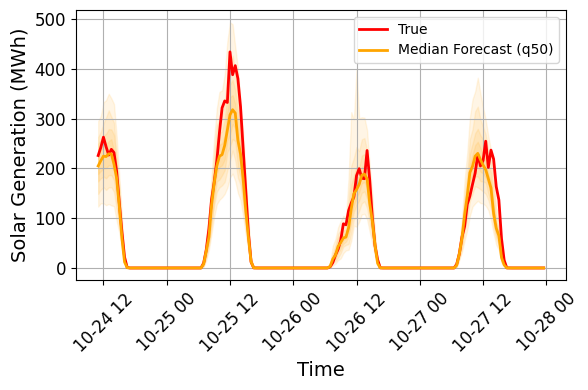

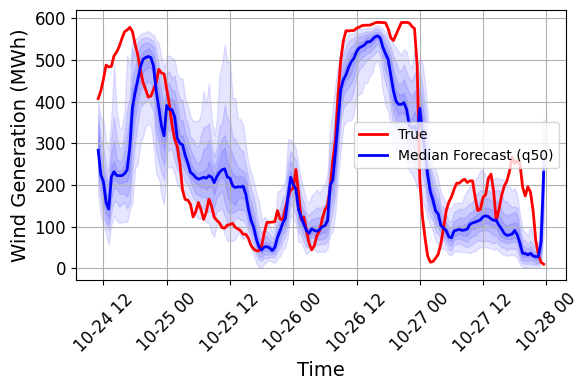

In [11]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
n_q = len(quantiles)
num_half_h = 170

# SUNNY D
t_slice = t_test[-num_half_h:]
y_true_slice = y_test_solar.values[-num_half_h:]
y_quantile_slice = y_p_solar_unscaled[-num_half_h:]

plt.figure(figsize=(6, 4))

plt.plot(t_slice, y_true_slice, label='True', color='red', linewidth=2)

# Plot quantile bands
for i in range(n_q // 2):
    lower = y_quantile_slice[:, i]
    upper = y_quantile_slice[:, -(i + 1)]
    plt.fill_between(t_slice, lower, upper, color='orange', alpha=0.1)

# Median line
plt.plot(t_slice, y_quantile_slice[:, 4], label='Median Forecast (q50)', color='orange', linewidth=2)

plt.xlabel("Time", fontsize=14)
plt.ylabel("Solar Generation (MWh)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()

# save to EPS ? 
#plt.savefig("quantile_solar_forecast_RFQR.eps", format='eps', dpi=300, bbox_inches='tight')
plt.show()

# WINDY BOY
# Use last 170 samples as an example
t_slice = t_test[-170:]
y_true_slice = y_test_wind.values[-170:]
y_quantile_slice = y_p_wind_unscaled[-170:]  # shape (170, 9)

plt.figure(figsize=(6, 4))

plt.plot(t_slice, y_true_slice, label='True', color='red', linewidth=2)

# Plot symmetric quantile bands (e.g. q10–q90, q20–q80, ...)
for i in range(n_q // 2):
    lower = y_quantile_slice[:, i]
    upper = y_quantile_slice[:, -(i + 1)]
    plt.fill_between(t_slice, lower, upper, color='blue', alpha=0.1)

# Median line (q50)
plt.plot(t_slice, y_quantile_slice[:, 4], label='Median Forecast (q50)', color='blue', linewidth=2)

plt.xlabel("Time", fontsize=14)
plt.ylabel("Wind Generation (MWh)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()

# EPS ?
#plt.savefig("quantile_wind_forecast_RFQR.eps", format='eps', dpi=300, bbox_inches='tight')

plt.show()


In [20]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import RandomizedSearchCV

# our lovely pinball functions 
def pinball(y, q, alpha):
    return (y - q) * alpha * (y >= q) + (q - y) * (1 - alpha) * (y < q)

def pinball_score(df):
    scores = [
        pinball(df["total_generation_MWh"], df[f"q{qu}"], alpha=qu / 100).mean()
        for qu in range(10, 100, 10)
    ]
    return np.mean(scores)

def custom_pinball_scorer(estimator, X, y_true):
    preds = estimator.predict(X)
    df = pd.DataFrame(preds, columns=[f"q{int(q * 100)}" for q in estimator.quantiles])
    df["total_generation_MWh"] = y_true.reset_index(drop=True)
    return -pinball_score(df)

# wrapper 
class QuantileWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, base_estimator=None, quantiles=None):
        self.base_estimator = base_estimator
        self.quantiles = quantiles

    def fit(self, X, y):
        self.base_estimator.fit(X, y)
        return self

    def predict(self, X):
        return self.base_estimator.predict(X, quantiles=self.quantiles)

# quantiles and parameters
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

param_distributions = {
    "base_estimator__n_estimators": [50, 100, 200, 300, 400, 500],
    "base_estimator__max_depth": [None, 5, 10, 15, 20, 25, 30],
    "base_estimator__min_samples_split": [2, 5, 10, 15, 20],
    "base_estimator__min_samples_leaf": [1, 2, 4, 8, 10],
    "base_estimator__max_features": ['sqrt', 'log2', None, 0.3, 0.5, 0.7],
    "base_estimator__max_samples": [None, 0.5, 0.7, 0.9],  
#    "base_estimator__bootstrap": [True, False]
}

# solar
print("Tuning Solar Model...")
solar_base = RandomForestQuantileRegressor(random_state=42, n_jobs=-1, criterion="squared_error")# "absolute_error" if you want to suffer
solar_model = QuantileWrapper(base_estimator=solar_base, quantiles=quantiles)

solar_search = RandomizedSearchCV(
    estimator=solar_model,
    param_distributions=param_distributions,
    n_iter=30,
    scoring=custom_pinball_scorer,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
solar_search.fit(X_train_solar_scaled, y_train_solar_scaled)
best_solar = solar_search.best_estimator_

# wind
print("Tuning Wind Model...")
wind_base = RandomForestQuantileRegressor(random_state=42, n_jobs=-1, criterion="squared_error")
wind_model = QuantileWrapper(base_estimator=wind_base, quantiles=quantiles)

wind_search = RandomizedSearchCV(
    estimator=wind_model,
    param_distributions=param_distributions,
    n_iter=30,
    scoring=custom_pinball_scorer,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
wind_search.fit(X_train_wind_scaled, y_train_wind_scaled)
best_wind = wind_search.best_estimator_

# predict and unscale 
print("Predicting...")
y_p_solar_scaled = best_solar.predict(X_test_solar_scaled)
y_p_wind_scaled = best_wind.predict(X_test_wind_scaled)

y_p_solar_unscaled = y_sun_scale.inverse_transform(y_p_solar_scaled)
y_p_wind_unscaled = y_wind_scale.inverse_transform(y_p_wind_scaled)

y_p_combined_unscaled = y_p_solar_unscaled + y_p_wind_unscaled

# prediction dfs 
df_solar = pd.DataFrame(y_p_solar_unscaled, columns=[f"q{int(q*100)}" for q in quantiles])
df_solar["total_generation_MWh"] = y_test_solar.reset_index(drop=True)

df_wind = pd.DataFrame(y_p_wind_unscaled, columns=[f"q{int(q*100)}" for q in quantiles])
df_wind["total_generation_MWh"] = y_test_wind.reset_index(drop=True)

df_total = pd.DataFrame(y_p_combined_unscaled, columns=[f"q{int(q*100)}" for q in quantiles])
df_total["total_generation_MWh"] = y_test_wps.reset_index(drop=True)

# final scores
score_total = pinball_score(df_total)
score_solar = pinball_score(df_solar)
score_wind  = pinball_score(df_wind)

print(f"Best Solar Parameters: {solar_search.best_params_}")
print(f"Best Wind Parameters:  {wind_search.best_params_}")

print(f"Pinball score (Total): {score_total:.4f}")
print(f"Pinball score (Solar): {score_solar:.4f}")
print(f"Pinball score (Wind):  {score_wind:.4f}")

# 65/35 split
# results, X and y scaled, search
# Pinball score (Total): 26.7396
# Pinball score (Solar): 9.6412
# Pinball score (Wind):  21.5460

# 80/20 split, it took an hour to get 
# Pinball score (Total): 27.2934
# Pinball score (Solar): 11.3045
# Pinball score (Wind):  20.9556

# 80/20 split, with removed bootstaps parameter, it took my poor computer 74 min
#Pinball score (Total): 27.6821
#Pinball score (Solar): 11.2446
#Pinball score (Wind):  21.1534

Tuning Solar Model...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Tuning Wind Model...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Predicting...
Best Solar Parameters: {'base_estimator__n_estimators': 500, 'base_estimator__min_samples_split': 15, 'base_estimator__min_samples_leaf': 8, 'base_estimator__max_samples': 0.9, 'base_estimator__max_features': 'sqrt', 'base_estimator__max_depth': 15}
Best Wind Parameters:  {'base_estimator__n_estimators': 400, 'base_estimator__min_samples_split': 10, 'base_estimator__min_samples_leaf': 4, 'base_estimator__max_samples': 0.5, 'base_estimator__max_features': 'log2', 'base_estimator__max_depth': 5}
Pinball score (Total): 27.6821
Pinball score (Solar): 11.2446
Pinball score (Wind):  21.1534


In [ ]:
# metrics 
# No Search, training 
metrics_solar = evaluate_forecast(df_solar, quant)
metrics_wind = evaluate_forecast(df_wind, quant)
metrics_combined = evaluate_forecast(df_total, quant)

print("Solar:", metrics_solar)
print("Wind:", metrics_wind)
print("Combined:", metrics_combined)

#Solar: {'MAE': 28.655362651502852, 'MAPE': np.float64(404.3554471660839), 'SMAPE': np.float64(19.060332363769053), 'RMSE': np.float64(55.78493732908805), 'R2': 0.9391795379766527, 'CRPS': np.float64(11.244606864109024), 'WIS': np.float64(131.23459370043392)}
#Wind: {'MAE': 52.89462865037535, 'MAPE': np.float64(1037.0850061171186), 'SMAPE': np.float64(49.418758161851464), 'RMSE': np.float64(86.43908944274511), 'R2': 0.8230295602113301, 'CRPS': np.float64(21.1533843475167), 'WIS': np.float64(244.5811957871703)}
#Combined: {'MAE': 68.5014495721642, 'MAPE': np.float64(17311.647472363522), 'SMAPE': np.float64(31.099468263968955), 'RMSE': np.float64(103.40108038067324), 'R2': 0.8736985107539081, 'CRPS': np.float64(27.682106518698205), 'WIS': np.float64(321.4016945237468)} 



Solar: {'MAE': 28.655362651502852, 'MAPE': np.float64(404.3554471660839), 'SMAPE': np.float64(19.060332363769053), 'RMSE': np.float64(55.78493732908805), 'R2': 0.9391795379766527, 'CRPS': np.float64(11.244606864109024), 'WIS': np.float64(131.23459370043392)}
Wind: {'MAE': 52.89462865037535, 'MAPE': np.float64(1037.0850061171186), 'SMAPE': np.float64(49.418758161851464), 'RMSE': np.float64(86.43908944274511), 'R2': 0.8230295602113301, 'CRPS': np.float64(21.1533843475167), 'WIS': np.float64(244.5811957871703)}
Combined: {'MAE': 68.5014495721642, 'MAPE': np.float64(17311.647472363522), 'SMAPE': np.float64(31.099468263968955), 'RMSE': np.float64(103.40108038067324), 'R2': 0.8736985107539081, 'CRPS': np.float64(27.682106518698205), 'WIS': np.float64(321.4016945237468)}


C:\Users\kjmli\AppData\Local\Temp\ipykernel_19500\3923378461.py:7: RuntimeWarning: invalid value encountered in divide
  diff = np.abs(y_true - y_pred) / denominator


<Figure size 1500x600 with 0 Axes>

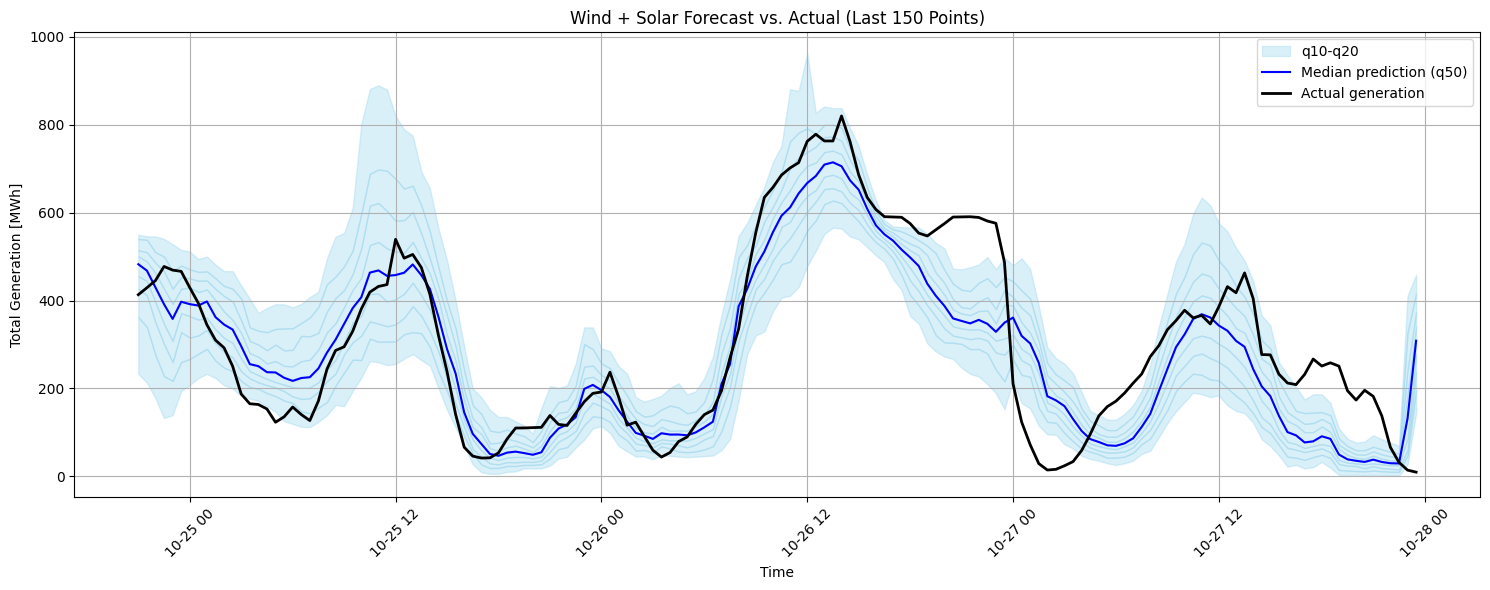

In [16]:
# Show results for qunatie forest for the last 150 point
N = 150 
plot_df = df_preds.tail(N).reset_index(drop=True)
time_axis = t_test.tail(N).reset_index(drop=True)

plt.figure(figsize=(15, 6))

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# Plot quantile bands
for lower, upper in zip(range(10, 90, 10), range(20, 100, 10)):
    plt.fill_between(
        time_axis,
        plot_df[f"q{lower}"],
        plot_df[f"q{upper}"],
        color="skyblue",
        alpha=0.3,
        label=f"q{lower}-q{upper}" if lower == 10 else None
    )

# Median prediction
plt.plot(time_axis, plot_df["q50"], label="Median prediction (q50)", color="blue")

# Actual generation
plt.plot(time_axis, plot_df["total_generation_MWh"], label="Actual generation", color="black", linewidth=2)

plt.title("Wind + Solar Forecast vs. Actual (Last 150 Points)")
plt.xlabel("Time")
plt.ylabel("Total Generation [MWh]")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate for readability
plt.tight_layout()
plt.show()


In [10]:
# prepross_comp
# note comp runs from feb to apr 2024 

# get X and y for testing with competition
start_date_comp = pd.Timestamp("2024-02-20 00:00:00+00:00")
end_date_comp = pd.Timestamp("2024-05-19 23:30:00+00:00")

# Extract y 
energy_data_2 = pd.read_csv("data_comp/Energy_Data_20240119_20240519.csv")
energy_data_2["dtm"] = pd.to_datetime(energy_data_2["dtm"])

# take out desierd interval 
filtered_data = energy_data_2[
    (energy_data_2["dtm"] >= start_date_comp) &
    (energy_data_2["dtm"] <= end_date_comp)
].copy()

filtered_data["Wind_MWh_credit"] = 0.5*filtered_data["Wind_MW"] - filtered_data["boa_MWh"]
filtered_data["Solar_MWh_credit"] = 0.5*filtered_data["Solar_MW"]
filtered_data["total_generation_MWh"] = filtered_data["Wind_MWh_credit"] + filtered_data["Solar_MWh_credit"]

# Double checking data
#has_nans = filtered_data["total_generation_MWh"].isna().any()
#print("Contains NaNs:", has_nans) # no NaNs good 
#display(filtered_data)

y_true_comp_solar = filtered_data["Solar_MWh_credit"].values
y_true_comp_wind = filtered_data["Wind_MWh_credit"].values
y_true_comp = filtered_data["total_generation_MWh"].values

# Extract X_test_comp 
model_table = pd.read_csv("data_comp/forecast_data_merged_comp.csv")

# convert to datetime
model_table["reference_time"] = pd.to_datetime(model_table["reference_time"])
model_table["valid_time"] = pd.to_datetime(model_table["valid_time"])

# copy previous methods 
X_latest_forcast_comp = pd.DataFrame() 
first_day = pd.Timestamp("2024-01-29 00:00:00+00:00")
num_day = model_table["reference_time"].dt.date.nunique()

for d in range(num_day):
       start = (first_day + timedelta(hours=18)) + timedelta(days=d)
       end = start + timedelta(hours=24)
       mask = (model_table["reference_time"] == start) &\
              (model_table["valid_time"] >= start + timedelta(hours=6)) &\
              (model_table["valid_time"] < end + + timedelta(hours=6))
       X_latest_forcast_comp = pd.concat([X_latest_forcast_comp, model_table.loc[mask]])

X_latest_forcast_comp = X_latest_forcast_comp.rename(columns={
    "valid_time": "valid_datetime"})

X_raw = model_table.copy()

X_raw["target_day"] = X_raw["valid_time"].dt.date
X_raw["reference_day"] = X_raw["reference_time"].dt.date
X_raw_filtered = X_raw[X_raw["reference_day"] == (X_raw["target_day"] - pd.Timedelta(days=1))]

X_overlapp_mean_comp = X_raw_filtered.groupby("valid_time", as_index=False).agg({
    "dwd_RelativeHumidity": "mean",
    "dwd_WindDirection_100": "mean",
    "dwd_WindSpeed_100": "mean",	
    "dwd_CloudCover": "mean",
    "dwd_SolarDownwardRadiation": "mean",	
    "dwd_Temperature": "mean",
    "ncep_RelativeHumidity": "mean",
    "ncep_WindDirection_100": "mean",
    "ncep_WindSpeed_100": "mean",
    "ncep_CloudCover": "mean",	
    "ncep_SolarDownwardRadiation": "mean",	
    "ncep_Temperature": "mean",
    "reference_time": ["first", "count"] 
})

X_overlapp_mean_comp.columns = [
    "_".join(col) if isinstance(col, tuple) else col 
    for col in X_overlapp_mean.columns
]

X_overlapp_mean_comp = X_overlapp_mean_comp.rename(columns={
    "reference_time_first": "ref_datetime",
    "reference_time_count": "n_forecasts",
    "dwd_RelativeHumidity_mean": "dwd_RelativeHumidity",
    "dwd_WindDirection_100_mean": "dwd_WindDirection_100",
    "dwd_WindSpeed_100_mean": "dwd_WindSpeed_100",
    "dwd_CloudCover_mean": "dwd_CloudCover",
    "dwd_SolarDownwardRadiation_mean": "dwd_SolarDownwardRadiation",	
    "dwd_Temperature_mean": "dwd_Temperature",
    "ncep_RelativeHumidity_mean": "ncep_RelativeHumidity",
    "ncep_WindDirection_100_mean": "ncep_WindDirection_100",
    "ncep_WindSpeed_100_mean": "ncep_WindSpeed_100",
    "ncep_CloudCover_mean": "ncep_CloudCover",
    "ncep_SolarDownwardRadiation_mean": "ncep_SolarDownwardRadiation",
    "ncep_Temperature_mean": "ncep_Temperature",
    "valid_time_": "valid_datetime"
})

# take out intervalls
filtered_X_lf = X_latest_forcast_comp[(X_latest_forcast_comp["valid_datetime"] >= start_date_comp) & (X_latest_forcast_comp["valid_datetime"] <= end_date_comp)]
filtered_X_mo = X_overlapp_mean_comp[(X_overlapp_mean_comp["valid_datetime"] >= start_date_comp) & (X_overlapp_mean_comp["valid_datetime"] <= end_date_comp)]

# split into solar and wind 
wind_features = ["valid_datetime", "dwd_RelativeHumidity", "dwd_WindDirection_100", "dwd_WindSpeed_100",
                "ncep_RelativeHumidity", "ncep_WindDirection_100", "ncep_WindSpeed_100"]

solar_features = ["valid_datetime","dwd_CloudCover", "dwd_SolarDownwardRadiation", "dwd_Temperature",
                "ncep_CloudCover", "ncep_SolarDownwardRadiation", "ncep_Temperature"]

X_comp_solar_lf = filtered_X_lf[solar_features]
X_comp_wind_lf = filtered_X_lf[wind_features]
X_comp_solar_mo = filtered_X_mo[solar_features]
X_comp_wind_mo = filtered_X_mo[wind_features]

# fitt transform
X_comp_solar = feature_engineering_solar.transform(X_comp_solar_lf)
X_comp_solar_scaled, _ = scale_features(arr=X_comp_solar, scaler=solar_scale)

X_comp_wind = feature_engineering_wind.transform(X_comp_wind_lf)
X_comp_wind_scaled, _ = scale_features(arr=X_comp_wind, scaler=wind_scale)

In [22]:
# Cool we compair with comp 
print("predicting solar")
#y_p_solar = rfq_solar.predict(X_comp_solar_scaled, quantiles=quant) # no search
y_p_solar = best_solar.predict(X_comp_solar_scaled)                # with search

print("predicting wind")
#y_p_wind = rfq_wind.predict(X_comp_wind_scaled, quantiles=quant) # no search
y_p_wind = best_wind.predict(X_comp_wind_scaled)               # with search
 
y_p_wind_unscaled_comp = y_wind_scale.inverse_transform(y_p_wind)
y_p_solar_unscaled_comp = y_sun_scale.inverse_transform(y_p_solar)
y_p_scaled_comp = y_p_wind_unscaled_comp + y_p_solar_unscaled_comp

# prediction dfs 
df_solar = pd.DataFrame(y_p_solar_unscaled_comp, columns=[f"q{int(q*100)}" for q in quant])
df_solar["total_generation_MWh"] = y_true_comp_solar

df_wind = pd.DataFrame(y_p_wind_unscaled_comp, columns=[f"q{int(q*100)}" for q in quant])
df_wind["total_generation_MWh"] = y_true_comp_wind

df_total = pd.DataFrame(y_p_scaled_comp, columns=[f"q{int(q*100)}" for q in quant])
df_total["total_generation_MWh"] = y_true_comp

# final scores
score_total = pinball_score(df_total)
score_solar = pinball_score(df_solar)
score_wind  = pinball_score(df_wind)

print(f"Pinball score (Total): {score_total:.4f}")
print(f"Pinball score (Solar): {score_solar:.4f}")
print(f"Pinball score (Wind):  {score_wind:.4f}")


# 65/35 split
# no search, X and y scaled no Remit; score Pinball score (wind + solar): 48.2260
# with search, X and y scaled no Remit; score Pinball score (wind + solar): 47.4339

# 80/20 split 
# no search, X and y scaled no Remit; score Pinball score (wind + solar): 47.8843

# without search, X and y scaled no Remit
#Pinball score (Total): 47.8843
#Pinball score (Solar): 14.0328
#Pinball score (Wind):  48.7486

# with search adjusted no bootstrap, X and y scaled no Remit
#Pinball score (Total): 47.5498
#Pinball score (Solar): 14.3717
#Pinball score (Wind):  47.8231



predicting solar
predicting wind
Pinball score (Total): 47.5498
Pinball score (Solar): 14.3717
Pinball score (Wind):  47.8231


In [ ]:
# Metric
metrics_solar = evaluate_forecast(df_solar, quant)
metrics_wind = evaluate_forecast(df_wind, quant)
metrics_combined = evaluate_forecast(df_preds, quant)

print("Solar:", metrics_solar)
print("Wind:", metrics_wind)
print("Combined:", metrics_combined)

# No search, no remit 
#Solar: {'MAE': 35.5471266949959, 'MAPE': np.float64(19413.491237918715), 'SMAPE': np.float64(25.677591723846234), 'RMSE': np.float64(73.80542620089496), 'R2': 0.8907951784775893, 'CRPS': np.float64(14.032807467701918), 'WIS': np.float64(161.2776903216958)}
#Wind: {'MAE': 114.37697241898148, 'MAPE': np.float64(472.1201462304941), 'SMAPE': np.float64(54.66703480303545), 'RMSE': np.float64(148.37380092588762), 'R2': 0.012515011015566069, 'CRPS': np.float64(48.74856451908436), 'WIS': np.float64(542.4953997890625)}
#Combined: {'MAE': 69.12101012085888, 'MAPE': np.float64(13799.29827903796), 'SMAPE': np.float64(30.224909080876845), 'RMSE': np.float64(104.33191937780691), 'R2': 0.8714142883826324, 'CRPS': np.float64(27.554255172782216), 'WIS': np.float64(320.02603988119694)}

# with search, no remit
#Solar: {'MAE': 36.31505945867392, 'MAPE': np.float64(283625.6037425446), 'SMAPE': np.float64(23.589355289793616), 'RMSE': np.float64(75.50411559066949), 'R2': 0.8857104617251416, 'CRPS': np.float64(14.37166877020345), 'WIS': np.float64(166.19214311882314)}
#Wind: {'MAE': 112.98204458333333, 'MAPE': np.float64(503.69985726352996), 'SMAPE': np.float64(58.38832210288894), 'RMSE': np.float64(147.47904757953162), 'R2': 0.024388959063027293, 'CRPS': np.float64(47.82313982260802), 'WIS': np.float64(533.1269497526042)}
#Combined: {'MAE': 69.12101012085888, 'MAPE': np.float64(13799.29827903796), 'SMAPE': np.float64(30.224909080876845), 'RMSE': np.float64(104.33191937780691), 'R2': 0.8714142883826324, 'CRPS': np.float64(27.554255172782216), 'WIS': np.float64(320.02603988119694)}


Solar: {'MAE': 36.31505945867392, 'MAPE': np.float64(283625.6037425446), 'SMAPE': np.float64(23.589355289793616), 'RMSE': np.float64(75.50411559066949), 'R2': 0.8857104617251416, 'CRPS': np.float64(14.37166877020345), 'WIS': np.float64(166.19214311882314)}
Wind: {'MAE': 112.98204458333333, 'MAPE': np.float64(503.69985726352996), 'SMAPE': np.float64(58.38832210288894), 'RMSE': np.float64(147.47904757953162), 'R2': 0.024388959063027293, 'CRPS': np.float64(47.82313982260802), 'WIS': np.float64(533.1269497526042)}
Combined: {'MAE': 69.12101012085888, 'MAPE': np.float64(13799.29827903796), 'SMAPE': np.float64(30.224909080876845), 'RMSE': np.float64(104.33191937780691), 'R2': 0.8714142883826324, 'CRPS': np.float64(27.554255172782216), 'WIS': np.float64(320.02603988119694)}


C:\Users\kjmli\AppData\Local\Temp\ipykernel_19500\3923378461.py:7: RuntimeWarning: invalid value encountered in divide
  diff = np.abs(y_true - y_pred) / denominator
C:\Users\kjmli\AppData\Local\Temp\ipykernel_19500\3923378461.py:7: RuntimeWarning: invalid value encountered in divide
  diff = np.abs(y_true - y_pred) / denominator


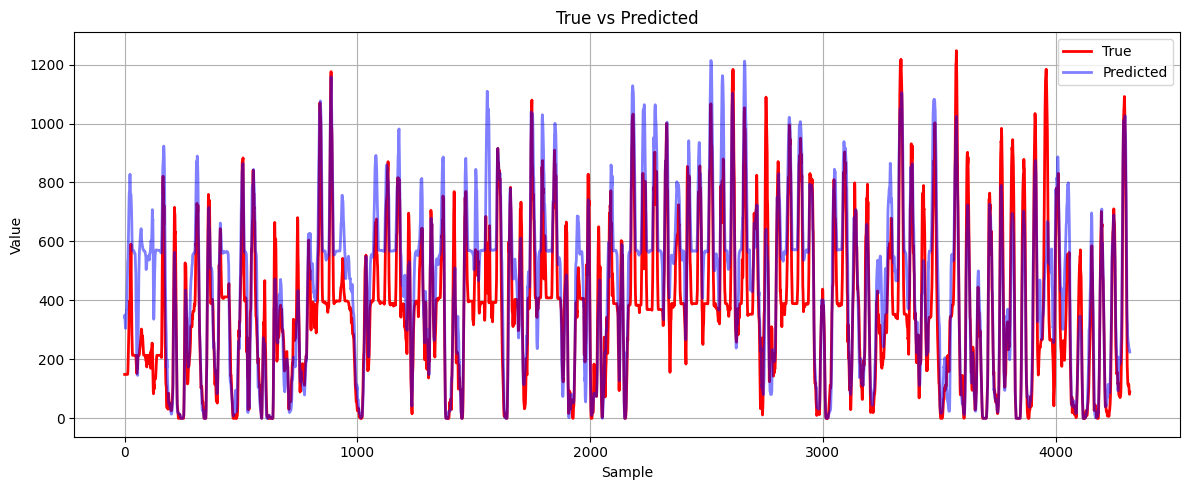

In [47]:
plt.figure(figsize=(12, 5))
plt.plot(y_true_comp, label='True', linewidth=2,  color="red")
plt.plot(df_preds["q50"].values, label='Predicted', linewidth=2, color="blue", alpha=0.5)

plt.title("True vs Predicted")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


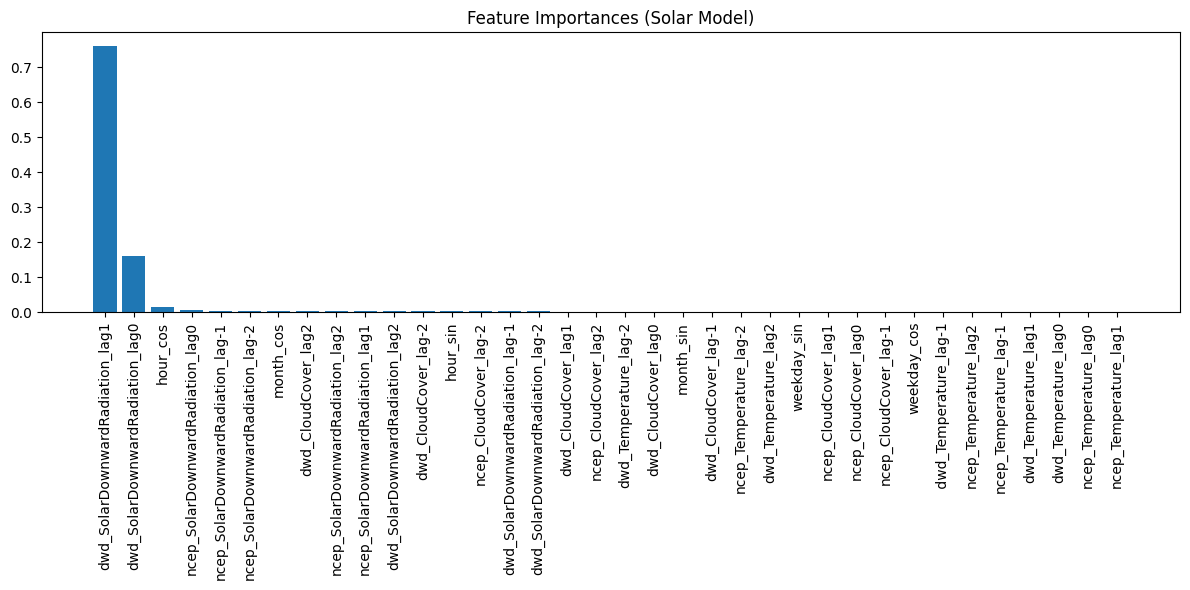

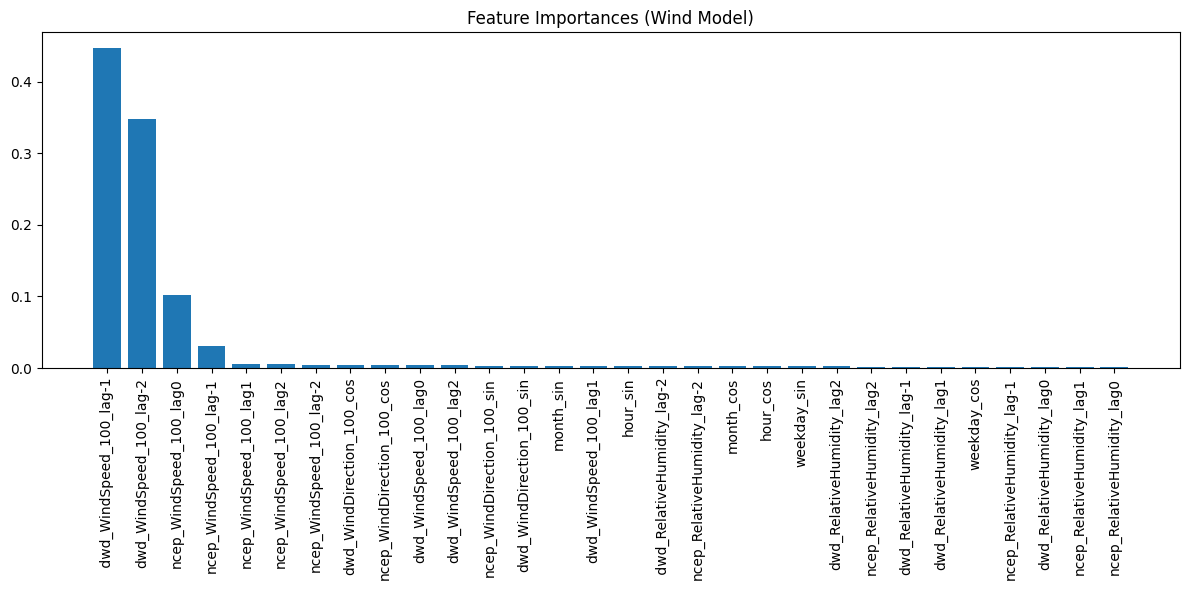

In [ ]:
# hello wanna see all feature importance for all 

feature_names = ["hour_sin", "hour_cos", "weekday_sin", "weekday_cos", "month_sin", "month_cos", "dwd_CloudCover_lag-2", "dwd_CloudCover_lag-1", "dwd_CloudCover_lag0", "dwd_CloudCover_lag1", "dwd_CloudCover_lag2", "dwd_SolarDownwardRadiation_lag-2", "dwd_SolarDownwardRadiation_lag-1", "dwd_SolarDownwardRadiation_lag0", "dwd_SolarDownwardRadiation_lag1", "dwd_SolarDownwardRadiation_lag2", "dwd_Temperature_lag-2"," dwd_Temperature_lag-1", "dwd_Temperature_lag0", "dwd_Temperature_lag1", "dwd_Temperature_lag2", "ncep_CloudCover_lag-2", "ncep_CloudCover_lag-1", "ncep_CloudCover_lag0", "ncep_CloudCover_lag1", "ncep_CloudCover_lag2", "ncep_SolarDownwardRadiation_lag-2", "ncep_SolarDownwardRadiation_lag-1", "ncep_SolarDownwardRadiation_lag0", "ncep_SolarDownwardRadiation_lag1", "ncep_SolarDownwardRadiation_lag2", "ncep_Temperature_lag-2", "ncep_Temperature_lag-1", "ncep_Temperature_lag0", "ncep_Temperature_lag1", "ncep_Temperature_lag2"]
# Get importances, Remeber that this is for no search 
importances = rfq_solar.feature_importances_

# Sort and plot
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances (Solar Model)")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

feature_names = ["hour_sin", "hour_cos", "weekday_sin", "weekday_cos", "month_sin", "month_cos", "dwd_WindDirection_100_sin", "dwd_WindDirection_100_cos", "ncep_WindDirection_100_sin", "ncep_WindDirection_100_cos"," dwd_RelativeHumidity_lag-2", "dwd_RelativeHumidity_lag-1", "dwd_RelativeHumidity_lag0", "dwd_RelativeHumidity_lag1", "dwd_RelativeHumidity_lag2", "dwd_WindSpeed_100_lag-2"," dwd_WindSpeed_100_lag-1", "dwd_WindSpeed_100_lag0", "dwd_WindSpeed_100_lag1", "dwd_WindSpeed_100_lag2", "ncep_RelativeHumidity_lag-2", "ncep_RelativeHumidity_lag-1", "ncep_RelativeHumidity_lag0", "ncep_RelativeHumidity_lag1", "ncep_RelativeHumidity_lag2", "ncep_WindSpeed_100_lag-2", "ncep_WindSpeed_100_lag-1", "ncep_WindSpeed_100_lag0", "ncep_WindSpeed_100_lag1", "ncep_WindSpeed_100_lag2"]

importances = rfq_wind.feature_importances_

# Sort and plot
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances (Wind Model)")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

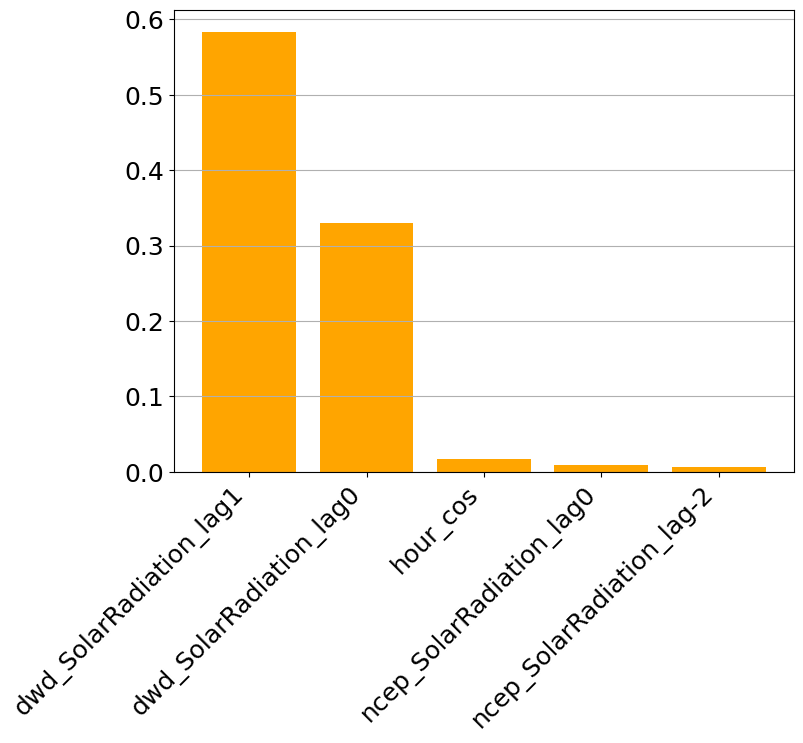

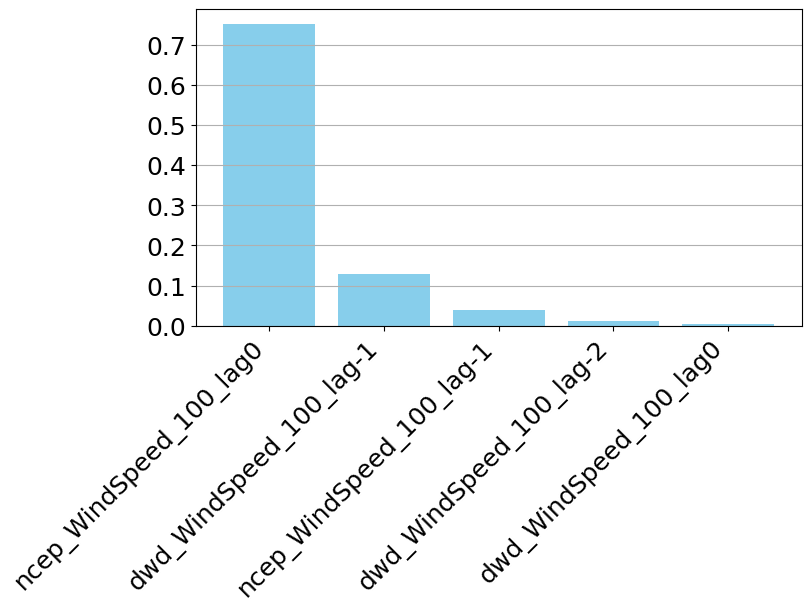

In [16]:
# aaaaahhhh
# solar 
feature_names_solar = [
    "hour_sin", "hour_cos", "weekday_sin", "weekday_cos", "month_sin", "month_cos",
    "dwd_CloudCover_lag-2", "dwd_CloudCover_lag-1", "dwd_CloudCover_lag0", "dwd_CloudCover_lag1", "dwd_CloudCover_lag2",
    "dwd_SolarRadiation_lag-2", "dwd_SolarRadiation_lag-1", "dwd_SolarRadiation_lag0",
    "dwd_SolarRadiation_lag1", "dwd_SolarRadiation_lag2",
    "dwd_Temperature_lag-2", "dwd_Temperature_lag-1", "dwd_Temperature_lag0",
    "dwd_Temperature_lag1", "dwd_Temperature_lag2",
    "ncep_CloudCover_lag-2", "ncep_CloudCover_lag-1", "ncep_CloudCover_lag0",
    "ncep_CloudCover_lag1", "ncep_CloudCover_lag2",
    "ncep_SolarRadiation_lag-2", "ncep_SolarRadiation_lag-1", "ncep_SolarRadiation_lag0",
    "ncep_SolarRadiation_lag1", "ncep_SolarRadiation_lag2",
    "ncep_Temperature_lag-2", "ncep_Temperature_lag-1", "ncep_Temperature_lag0",
    "ncep_Temperature_lag1", "ncep_Temperature_lag2"
]

importances_solar = rfq_solar.feature_importances_
indices_solar = np.argsort(importances_solar)[::-1][:5]

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 10})
plt.bar(range(5), importances_solar[indices_solar], color='orange')
plt.xticks(range(5), [feature_names_solar[i] for i in indices_solar], rotation=45, ha='right', fontsize=18)
plt.yticks(fontsize=18)
plt.grid(axis='y')
plt.savefig("quantile_solar_features_RFQR.eps", format='eps', dpi=300, bbox_inches='tight')
plt.show()

# wind 
feature_names_wind = [
    "hour_sin", "hour_cos", "weekday_sin", "weekday_cos", "month_sin", "month_cos",
    "dwd_WindDirection_100_sin", "dwd_WindDirection_100_cos",
    "ncep_WindDirection_100_sin", "ncep_WindDirection_100_cos",
    "dwd_RelativeHumidity_lag-2", "dwd_RelativeHumidity_lag-1", "dwd_RelativeHumidity_lag0",
    "dwd_RelativeHumidity_lag1", "dwd_RelativeHumidity_lag2",
    "dwd_WindSpeed_100_lag-2", "dwd_WindSpeed_100_lag-1", "dwd_WindSpeed_100_lag0",
    "dwd_WindSpeed_100_lag1", "dwd_WindSpeed_100_lag2",
    "ncep_RelativeHumidity_lag-2", "ncep_RelativeHumidity_lag-1", "ncep_RelativeHumidity_lag0",
    "ncep_RelativeHumidity_lag1", "ncep_RelativeHumidity_lag2",
    "ncep_WindSpeed_100_lag-2", "ncep_WindSpeed_100_lag-1", "ncep_WindSpeed_100_lag0",
    "ncep_WindSpeed_100_lag1", "ncep_WindSpeed_100_lag2"
]

importances_wind = rfq_wind.feature_importances_
indices_wind = np.argsort(importances_wind)[::-1][:5]

plt.figure(figsize=(8, 6), constrained_layout=True)
plt.rcParams.update({'font.size': 10})
plt.bar(range(5), importances_wind[indices_wind], color='skyblue')
plt.xticks(range(5), [feature_names_wind[i] for i in indices_wind], rotation=45, ha='right', fontsize=18)
plt.yticks(fontsize=18)
plt.grid(axis='y')
plt.savefig("quantile_wind_features_RFQR.eps", format='eps', dpi=300, bbox_inches='tight')
plt.show()


Okay the prediction is absolute ass, so let's try and take REMIT into account.

In [14]:
import pandas as pd
import xarray as xr
import numpy as np
import warnings
import json
warnings.simplefilter(action='ignore', category=FutureWarning)

start_date = pd.Timestamp("2024-02-20 00:00:00+00:00")
end_date = pd.Timestamp("2024-05-19 23:30:00+00:00")

# create df 
date_range = pd.date_range(start=start_date, end=end_date, freq="30min", tz="UTC")
df = pd.DataFrame({'dtm': date_range})
df["capacity_1"] = np.nan
df["capacity_2"] = np.nan
df["capacity_3"] = np.nan

# open remit files
with open("data_comp/REMIT/T_HOWAO-1-2023-05-20T00_00_00.000Z-2024-05-20T00_00_00.000Z.json", "r") as file:
    remit_data_1 = json.load(file)
with open("data_comp/REMIT/T_HOWAO-2-2023-05-20T00_00_00.000Z-2024-05-20T00_00_00.000Z.json", "r") as file:
    remit_data_2 = json.load(file)
with open("data_comp/REMIT/T_HOWAO-3-2023-05-20T00_00_00.000Z-2024-05-20T00_00_00.000Z.json", "r") as file:
    remit_data_3 = json.load(file)

def get_publish_time(item):
    publish_time = item.get("publishTime")
    if publish_time is None:
        return pd.NaT  # Not a Time, will be sorted last
    try:
        return pd.Timestamp(publish_time)
    except:
        return pd.NaT

def round_to_nearest_half_hour(dt):
    dt = pd.Timestamp(dt)
    discard = pd.Timedelta(minutes=dt.minute % 30,
                           seconds=dt.second,
                           microseconds=dt.microsecond)
    dt -= discard
    if discard >= pd.Timedelta(minutes=15):
        dt += pd.Timedelta(minutes=30)
    return dt

# filter out for start and end dates 
filtered_data_1 = []
for item in remit_data_1:
    for profile in item.get("outageProfile", []):
        profile_start = pd.Timestamp(profile["startTime"])
        profile_end = pd.Timestamp(profile["endTime"])
        
        if profile_end >= start_date and profile_start <= end_date:
            filtered_data_1.append(item)
            break

filtered_data_2 = []
for item in remit_data_2:
    for profile in item.get("outageProfile", []):
        profile_start = pd.Timestamp(profile["startTime"])
        profile_end = pd.Timestamp(profile["endTime"])
        
        if profile_end >= start_date and profile_start <= end_date:
            filtered_data_2.append(item)
            break

filtered_data_3 = []
for item in remit_data_3:
    for profile in item.get("outageProfile", []):
        profile_start = pd.Timestamp(profile["startTime"])
        profile_end = pd.Timestamp(profile["endTime"])
        
        if profile_end >= start_date and profile_start <= end_date:
            filtered_data_3.append(item)
            break

# Sort the filtered data
sorted_filtered_data_1 = sorted(
    filtered_data_1,
    key=lambda x: get_publish_time(x),
    reverse=False  # Set to True for descending order
)

sorted_filtered_data_2 = sorted(
    filtered_data_2,
    key=lambda x: get_publish_time(x),
    reverse=False  # Set to True for descending order
)

sorted_filtered_data_3 = sorted(
    filtered_data_3,
    key=lambda x: get_publish_time(x),
    reverse=False  # Set to True for descending order
)

print("-"*50)
# store data in df 
for item in filtered_data_1:
    for profile in item.get("outageProfile", []):
        # Round start and end times
        start = round_to_nearest_half_hour(profile["startTime"])
        end = round_to_nearest_half_hour(profile["endTime"])

        # Skip if interval is fully outside the window
        if end < start_date or start > end_date:
            continue

        # Define mask and fill in capacity
        mask = (df["dtm"] >= start) & (df["dtm"] <= end)

        existing = df.loc[mask, "capacity_1"]
        new_value = profile["capacity"]
        conflict = (existing.notna()) & (existing != new_value)
        if conflict.any():
            print(f"Conflict at {start} - {end}: existing values differ from new capacity {new_value}")
        df.loc[mask, "capacity_1"] = profile["capacity"]


print("-"*50)
for item in filtered_data_2:
    for profile in item.get("outageProfile", []):
        # Round start and end times
        start = round_to_nearest_half_hour(profile["startTime"])
        end = round_to_nearest_half_hour(profile["endTime"])

        # Skip if interval is fully outside the window
        if end < start_date or start > end_date:
            continue

        # Define mask and fill in capacity
        mask = (df["dtm"] >= start) & (df["dtm"] <= end)

        existing = df.loc[mask, "capacity_2"]
        new_value = profile["capacity"]
        conflict = (existing.notna()) & (existing != new_value)
        if conflict.any():
            print(f"Conflict at {start} - {end}: existing values differ from new capacity {new_value}")
        df.loc[mask, "capacity_2"] = profile["capacity"]


print("-"*50)
for item in filtered_data_3:
    for profile in item.get("outageProfile", []):
        # Round start and end times
        start = round_to_nearest_half_hour(profile["startTime"])
        end = round_to_nearest_half_hour(profile["endTime"])

        # Skip if interval is fully outside the window
        if end < start_date or start > end_date:
            continue

        # Define mask and fill in capacity
        mask = (df["dtm"] >= start) & (df["dtm"] <= end)

        existing = df.loc[mask, "capacity_3"]
        new_value = profile["capacity"]
        conflict = (existing.notna()) & (existing != new_value)
        if conflict.any():
            print(f"Conflict at {start} - {end}: existing values differ from new capacity {new_value}")
        df.loc[mask, "capacity_3"] = profile["capacity"]


# fill NaNs with zeros
df.update(df[["capacity_1", "capacity_2", "capacity_3"]].fillna(0))
df["capacity_tot"] = df["capacity_1"] + df["capacity_2"] + df["capacity_3"]

#df.to_csv("data_comp/REMIT_capacity_comp.csv")

--------------------------------------------------
Conflict at 2024-01-30 12:00:00+00:00 - 2024-05-15 19:00:00+00:00: existing values differ from new capacity 232
Conflict at 2024-05-02 08:00:00+00:00 - 2024-05-14 16:00:00+00:00: existing values differ from new capacity 200
Conflict at 2024-01-30 12:00:00+00:00 - 2024-05-02 09:00:00+00:00: existing values differ from new capacity 232
Conflict at 2024-05-02 09:00:00+00:00 - 2024-05-11 16:00:00+00:00: existing values differ from new capacity 0
Conflict at 2024-05-11 16:00:00+00:00 - 2024-05-14 16:00:00+00:00: existing values differ from new capacity 200
Conflict at 2024-01-30 12:00:00+00:00 - 2024-05-03 09:00:00+00:00: existing values differ from new capacity 232
Conflict at 2024-05-03 09:00:00+00:00 - 2024-05-12 16:00:00+00:00: existing values differ from new capacity 0
Conflict at 2024-05-12 16:00:00+00:00 - 2024-05-15 16:00:00+00:00: existing values differ from new capacity 200
Conflict at 2024-01-30 12:00:00+00:00 - 2024-05-04 09:00:

Pinball score (Total): 32.3018
Pinball score (Solar): 14.3717
Pinball score (Wind):  27.3709


NameError: name 'df_preds_2' is not defined

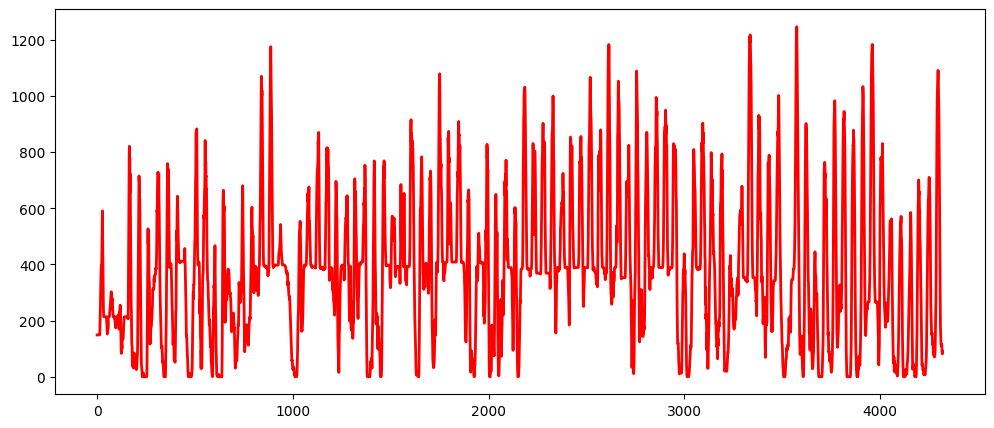

In [26]:
#display(df)
#display(filtered_data_1) #   'normalCapacity': 400,
#display(filtered_data_2) #   'normalCapacity': 400,
#display(filtered_data_3) #   'normalCapacity': 400,
df["capacity_1_scaled"] = df["capacity_1"]/(400)
df["capacity_2_scaled"] = df["capacity_2"]/(400)
df["capacity_3_scaled"] = df["capacity_3"]/(400)
df["capacity_tot_scaled"] = (df["capacity_1_scaled"] + df["capacity_2_scaled"] + df["capacity_3_scaled"])
#print(df_preds.shape)
#display(df_preds)

y_wind_remited = y_p_wind_unscaled_comp * df["capacity_tot_scaled"].to_numpy().reshape(-1, 1)

y_p_comp_2 = y_p_solar_unscaled_comp + y_wind_remited

# prediction dfs 
df_solar = pd.DataFrame(y_p_solar_unscaled_comp, columns=[f"q{int(q*100)}" for q in quant])
df_solar["total_generation_MWh"] = y_true_comp_solar

df_wind = pd.DataFrame(y_wind_remited, columns=[f"q{int(q*100)}" for q in quant])
df_wind["total_generation_MWh"] = y_true_comp_wind

df_total = pd.DataFrame(y_p_comp_2, columns=[f"q{int(q*100)}" for q in quant])
df_total["total_generation_MWh"] = y_true_comp

# final scores
score_total = pinball_score(df_total)
score_solar = pinball_score(df_solar)
score_wind  = pinball_score(df_wind)

print(f"Pinball score (Total): {score_total:.4f}")
print(f"Pinball score (Solar): {score_solar:.4f}")
print(f"Pinball score (Wind):  {score_wind:.4f}")

plt.figure(figsize=(12, 5))
plt.plot(y_true_comp, label='True', linewidth=2,  color="red")
plt.plot(df_preds_2["q50"].values, label='Predicted', linewidth=2, color="blue", alpha=0.5)

plt.title("True vs Predicted")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 65/35 split
# Score: 32.7630 with Remit no search, X and y scaled 
# Score: 32.1885 with Remit and searched, X and y scaled

# 80/20 split 
# Score: 32.9122 with Remit no search, X and y scaled 
# Pinball score (Total): 32.9122
# Pinball score (Solar): 14.0328
# Pinball score (Wind):  28.4872


# With REMIT AND adjusted search, X and y scaled
# Pinball score (Total): 32.3018
# Pinball score (Solar): 14.3717
# Pinball score (Wind):  27.3709


In [ ]:
# Metrics for comp
metrics_solar = evaluate_forecast(df_solar, quant)
metrics_wind = evaluate_forecast(df_wind, quant)
metrics_combined = evaluate_forecast(df_total, quant)

print("Solar:", metrics_solar)
print("Wind:", metrics_wind)
print("Combined:", metrics_combined)

# with Remit, no search
#Solar: {'MAE': 35.5471266949959, 'MAPE': np.float64(19413.491237918715), 'SMAPE': np.float64(25.677591723846234), 'RMSE': np.float64(73.80542620089496), 'R2': 0.8907951784775893, 'CRPS': np.float64(14.032807467701918), 'WIS': np.float64(161.2776903216958)}
#Wind: {'MAE': 69.0202626316551, 'MAPE': np.float64(374.97751936622933), 'SMAPE': np.float64(45.75662669398663), 'RMSE': np.float64(122.44508099389265), 'R2': 0.3274900044251049, 'CRPS': np.float64(28.48722824253151), 'WIS': np.float64(322.184633727949)}
#Combined: {'MAE': 81.69624922404327, 'MAPE': np.float64(304.3615484850516), 'SMAPE': np.float64(31.78076719209685), 'RMSE': np.float64(131.05206841895725), 'R2': 0.7338913737602208, 'CRPS': np.float64(32.912248318094385), 'WIS': np.float64(377.96272413858134)}

# with Remit, with search
#Solar: {'MAE': 36.31505945867392, 'MAPE': np.float64(283625.6037425446), 'SMAPE': np.float64(23.589355289793616), 'RMSE': np.float64(75.50411559066949), 'R2': 0.8857104617251416, 'CRPS': np.float64(14.37166877020345), 'WIS': np.float64(166.19214311882314)}
#Wind: {'MAE': 67.62673512008102, 'MAPE': np.float64(398.25106015646907), 'SMAPE': np.float64(49.82304843347912), 'RMSE': np.float64(118.25744191260148), 'R2': 0.3727032771868348, 'CRPS': np.float64(27.370932410612784), 'WIS': np.float64(311.44301363433163)}
#Combined: {'MAE': 81.44064008884715, 'MAPE': np.float64(535.9641373636908), 'SMAPE': np.float64(33.95365915845396), 'RMSE': np.float64(128.53454103605432), 'R2': 0.7440171349885187, 'CRPS': np.float64(32.301774082120055), 'WIS': np.float64(373.70822304350776)}


Solar: {'MAE': 36.31505945867392, 'MAPE': np.float64(283625.6037425446), 'SMAPE': np.float64(23.589355289793616), 'RMSE': np.float64(75.50411559066949), 'R2': 0.8857104617251416, 'CRPS': np.float64(14.37166877020345), 'WIS': np.float64(166.19214311882314)}
Wind: {'MAE': 67.62673512008102, 'MAPE': np.float64(398.25106015646907), 'SMAPE': np.float64(49.82304843347912), 'RMSE': np.float64(118.25744191260148), 'R2': 0.3727032771868348, 'CRPS': np.float64(27.370932410612784), 'WIS': np.float64(311.44301363433163)}
Combined: {'MAE': 81.44064008884715, 'MAPE': np.float64(535.9641373636908), 'SMAPE': np.float64(33.95365915845396), 'RMSE': np.float64(128.53454103605432), 'R2': 0.7440171349885187, 'CRPS': np.float64(32.301774082120055), 'WIS': np.float64(373.70822304350776)}


C:\Users\kjmli\AppData\Local\Temp\ipykernel_19500\3923378461.py:7: RuntimeWarning: invalid value encountered in divide
  diff = np.abs(y_true - y_pred) / denominator
